In [1]:
%load_ext autoreload
%matplotlib inline

In [327]:
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.font_manager as fm
import matplotlib.cm as cmx
import xarray as xr
import os,sys,glob
import datetime

from PIL import Image,ImageSequence
from matplotlib.patches import Circle
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap

## Add own library to path
workdir = os.getcwd()
repodir = workdir
projectname = 'EUREC4A'
while os.path.basename(repodir) != projectname:
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
## Own functions
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)

# local input directory
# localinputdir = os.path.join(repodir,'inputdata')
sondedir = '/Users/bfildier/Data/EUREC4A/Measurements/HALO'
goesdir = os.path.join(repodir,'outputs/figures')
outputdir = os.path.join(repodir,'outputs/movies')

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

repo: /Users/bfildier/Code/analyses/EUREC4A/EUREC4A


In [66]:
def imageNameRoot(dtime):
    
    date_str = dtime.strftime('%Y-%m-%d')
        
    minutes = dtime.minute
    
    # pick time rounded to closest 10mn increment
    hr_goes = dtime.hour
    min_goes = round(dtime.minute/10)*10 # round min to closest 10mn
    hr_goes += int((min_goes/60)) # increment if round to next hour
    min_goes = min_goes%60
    dtime_goes = datetime.datetime(year=dtime.year,
                                   month=dtime.month,
                                   day=dtime.day,
                                   hour=hr_goes,
                                   minute=min_goes)
    
    # path of image
    nameroot = dtime_goes.strftime('%Y-%m-%dT%H:%M:00Z')
    
    return nameroot


def loadImage(dtime,verbose=False):
    
    """Load GOES image at closest 10mn increment
    Arguments:
    - dtime: datetime object
    """
    
    nameroot = imageNameRoot(dtime)
    
    # path of image
    fullpath = os.path.join(goesdir,nameroot[:10],nameroot+'.jpg')
    if verbose:
        print('load image %s.jpg'%nameroot)
    
    # load and return image
    return Image.open(fullpath)

def outputFileName(dtime):
    
    nameroot = imageNameRoot(dtime)
    
#     return nameroot+'_HALO.jpg'
    return nameroot+'_HALO.pdf'
    
# # TEST function
# now = datetime.datetime(year=2020,month=1,day=24,hour=15,minute=43)
# print(now)
# now_goes = loadImage(now)

In [349]:
t = (2,5)
print(t)

(2, 5)
(2, 5, 4, 3)


In [156]:
def loadSondes(dtime):
    
    allsondefiles = glob.glob(os.path.join(sondedir,
                                       dtime.strftime('%Y%m%d'),
                                       'AVAPS_Dropsondes/processed/*_PQC.nc'))
    allsondefiles.sort()
    
    allsondes = []
    
    for filepath in allsondefiles:
        
        allsondes.append(xr.open_dataset(filepath).dropna(dim='time',subset=['time']).swap_dims({'time':'alt'}).reset_coords().dropna(dim='alt',subset=['alt','time','lat','lon'],
                            how='any'))
    
    return allsondes

def getMatchingSondes(allsondes,dtime,dt_fade,nfill=None,verbose=False):
    
    """ 
    Arguments:
    - allsondes: list of all sondes already loaded
    - dtime: datetime object, current time
    - dt_fade: time window (mn) to fade out sondes that reached the surface
    
    Returns:
    - sondes: list of xarray objects"""
    
    sondes = []
    
    # window for fading out sonde display
    delta_fade = datetime.timedelta(minutes=dt_fade)
    
    for sonde in allsondes:
        
        launch_time = datetime.datetime.strptime(str(sonde.launch_time.values)[:16],
                                                '%Y-%m-%dT%H:%M')

        # If sonde currently falling or fell in the past dt_fade mn
        if launch_time <= dtime and launch_time + delta_fade > dtime:
                
            if verbose:
                print('keep ',launch_time)
                
            # Then load sonde data and store it
            sondes.append(sonde)
    
    # fill list of nfill elements with empty sonde objects
    if nfill is None:
        return sondes
    elif nfill > len(sondes):
        return sondes+[None]*(nfill-len(sondes))
    else:
        return sondes[:nfill]

In [5]:
## OLD VERSION, NOT NEEDED

def loadMatchingSondes(dtime,dt_fade,verbose=False):
    
    """ 
    Arguments:
    - dtime: datetime object, current time
    - dt_fade: time window (mn) to fade out sondes that reached the surface
    
    Returns:
    - sondes: list of xarray objects"""
    
    allsondefiles = glob.glob(os.path.join(sondedir,
                                       dtime.strftime('%Y%m%d'),
                                       'AVAPS_Dropsondes/processed/*_PQC.nc'))
    allsondefiles.sort()
    sondes = []
    
    # window for fading out sonde display
    delta_fade = datetime.timedelta(minutes=dt_fade)
    
    for filepath in allsondefiles:
        
        filename = os.path.basename(filepath)
        time_sonde = datetime.datetime.strptime(filename,
                                                'D%Y%m%d_%H%M%S_PQC.nc')
#         time_sonde.second = 0 # set seconds to zero

        # If sonde currently falling or fell in the past dt_fade mn
        if time_sonde <= dtime and time_sonde + delta_fade > dtime:
                
            if verbose:
                print('keep ',time_sonde)
                
            # Then load sonde data and store it
            sondes.append(xr.open_dataset(filepath).dropna(dim='time',subset=['time']).swap_dims({'time':'alt'}).reset_coords().dropna(dim='alt',subset=['alt','time','lat','lon'],
                            how='any'))#.\
#                             interp(alt=np.arange(0,9100,10)))
    
    return sondes
    
# # TEST function
# now = datetime.datetime(year=2020,month=1,day=24,hour=15,minute=43)
# print('now:',now)
# sondes = loadMatchingSondes(now,60,verbose=True)

# print(len(sondes))

In [6]:
def addCircle(ax):
    
    """Plot HALO circle on argument ax"""
    
    pass

In [96]:
def showSonde(ax,dtime,sonde,cmap_falling=plt.cm.GnBu,altmax=9100,col_fading='darkorange',showtime=True):
    
    dtime_str = dtime.strftime('%Y-%m-%dT%H:%M')
    sonde_times = np.array([str(sonde.time[i].values)[:16] for i in range(sonde.time.size)])
    matching_times = np.where(sonde_times == dtime_str)[0]

    if matching_times.size == 0: # no matching time, sonde on the ground
        falling = False
        i_dtime = 0
    else:
        falling = True
        i_dtime = matching_times[-1]
        
    # position of sonde at current time
    lon_sonde = sonde.lon.values[i_dtime]
    lat_sonde = sonde.lat.values[i_dtime]
    alt_sonde = sonde.alt.values[i_dtime]
    time_sonde = datetime.datetime.strptime(str(sonde.time.values[i_dtime])[:16],'%Y-%m-%dT%H:%M')
    launch_time = datetime.datetime.strptime(str(sonde.launch_time.values)[:16],'%Y-%m-%dT%H:%M')
    last_time = datetime.datetime.strptime(str(sonde.time.values[0])[:16],'%Y-%m-%dT%H:%M')
    
    # choose color based on height
    cNorm = colors.Normalize(vmin=0, vmax=altmax)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap_falling)
    fc = ec = scalarMap.to_rgba(alt_sonde)
    
    # color in darkorange if the sonde reached the ocean
    if dtime > last_time:
        fc = ec = col_fading
    # fix color for when sonde is just being launched
    if dtime == launch_time:
        fc = ec = col_top
    
    if falling:
        # color based on height
        alpha = 1
    else:
        # fade out coefficient
        delta_fade = datetime.timedelta(minutes=dt_fade)
        alpha = ((time_sonde+delta_fade)-dtime)/(delta_fade)
        if alpha > 1: alpha = 1 # correct for time rounding errors leading to alpha>1
        
    circ = Circle((lon_sonde,lat_sonde),0.03,linewidth=2,ec=ec,fc=fc,alpha=alpha)
    p = ax.add_patch(circ)
    
    # Show launch time
    t = None
    if showtime:
        t = ax.text(lon_sonde+0.05,lat_sonde+0.05,str(sonde.launch_time.values)[11:16],
                color=fc,alpha=alpha,fontsize=20)
        
    return p,t

In [346]:
def showTime(ax,dtime):
    
#     font = fm.FontProperties(family='Calibri Light',
#                                    style='normal', size=30)
#     fdict = {'family':'Lucida Grande'}
    
    t = ax.text(lonmin+0.1,latmax-0.45,dtime.strftime('%Y-%m-%d\n%H:%M UTC'),
            color='white',fontsize=30)

    return t

In [97]:
def showColorBar(ax,cmap):

    x,y,w,h = ax.get_position().bounds
    c_map_ax = fig.add_axes([x+0.8*w, y+0.05*h, 0.008*w, 0.5*h])
    cbar = mpl.colorbar.ColorbarBase(c_map_ax, cmap=cmap, orientation = 'vertical')
    cbar.ax.set_ylabel('z(km)',fontsize=20,color='w') # cbar legend
    h_values = np.linspace(0,altmax,6)
    cbar.ax.set_yticklabels(['%1.1f'%(v/1000) for v in h_values],fontsize=15) # set ticklabels
    cbar.ax.tick_params(axis='y',colors='w') # set tick color in white
    
    return cbar


In [10]:
print('define main parameters/arguments')

# time to fade out
dt_fade = 60

# aircraft altitude
altmax = 9100

# Image box
lonmin,lonmax = -60,-55
dlon = lonmin-lonmax
latmin,latmax = 11.5,15
dlat = latmin-latmax

# HALO circle
lon_center, lat_center = -57.717,13.3
lon_pt_circle, lat_pt_circle = -57.245,14.1903
r_circle = np.sqrt((lon_pt_circle-lon_center)**2+(lat_pt_circle-lat_center)**2)


define main parameters/arguments


In [13]:
# Load image
# now = datetime.datetime(year=2020,month=1,day=24,hour=10,minute=35)
now = datetime.datetime(year=2020,month=1,day=24,hour=10,minute=15)
print('try ',now)
goes_image = loadImage(now)
print()
print('load all sondes')
allsondes = loadSondes(now)
print()

# Load sondes
print('pick sondes to show')
# sondes = loadMatchingSondes(now,60,verbose=True)
sondes = getMatchingSondes(allsondes,now,60,verbose=True)
print()


try  2020-01-24 10:15:00
load image 2020-01-24T10:20:00Z.jpg

load all sondes

pick sondes to show
keep  2020-01-24 09:50:00
keep  2020-01-24 09:55:00
keep  2020-01-24 10:01:00
keep  2020-01-24 10:05:00
keep  2020-01-24 10:10:00
keep  2020-01-24 10:15:00



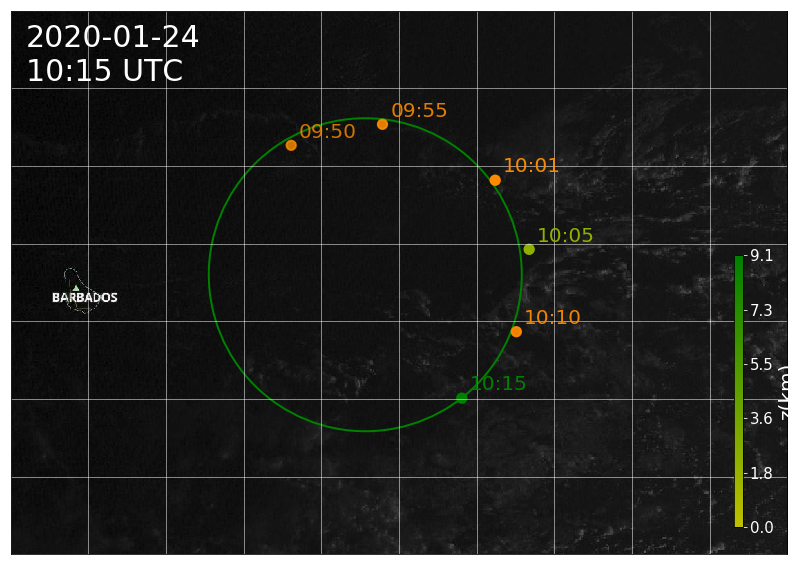

In [20]:
# PLOT

# fig,ax = plt.subplots(1,figsize=(20,10))
fig = plt.figure(figsize=(20,10))
ax = fig.gca()

# define colormap
# col_top = 'lime'
# col_top = 'springgreen'
# col_top = 'limegreen'
# col_top = 'deepskyblue'
col_top = 'g'
# col_bottom = 'deepskyblue'
# col_bottom = 'red'
# col_bottom = 'gold'
# col_bottom = 'deepskyblue'
# col_mid = 'yellow'
col_bottom = 'y'
cmap = LinearSegmentedColormap.from_list('mycmap', [col_bottom,col_top])

# show frame
h = ax.imshow(goes_image,aspect=1)
h.set_extent([lonmin,lonmax,latmin,latmax])

# add circle
circ = Circle((lon_center,lat_center),r_circle,linewidth=2,ec=col_top,fill=False)
ax.add_patch(circ)

# add grid
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.grid(color='w', linestyle='-', linewidth=0.5)

# show colorbar
showColorBar(ax,cmap)
    
# show sondes
for sonde in sondes:
    showSonde(ax,now,sonde,cmap_falling=cmap,altmax=altmax)
    
# show current time
showTime(ax,now)

# remove axes
ax.xaxis.set_ticklabels([])
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticklabels([])
ax.yaxis.set_ticks_position('none')

outputfilepath = os.path.join(outputdir,outputFileName(now))
# plt.savefig(outputfilepath,bbox_inches='tight')
# plt.savefig('test100dpi.jpeg',bbox_inches='tight',dpi=100)
plt.savefig('test50dpi.pdf',bbox_inches='tight',dpi=50)

In [98]:
def fillImage(ax,goes_im,dtime,allsondes,dt_fade,col_top,col_bottom):

    # create cmap
    cmap = LinearSegmentedColormap.from_list('mycmap', [col_bottom,col_top])

    # show frame
    im = ax.imshow(goes_im,aspect=1)
    im.set_extent([lonmin,lonmax,latmin,latmax])

    # add circle
    circ = Circle((lon_center,lat_center),r_circle,linewidth=2,ec=col_top,fill=False)
    ax.add_patch(circ)

    # add grid
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.grid(color='w', linestyle='-', linewidth=0.5)

    # show colorbar
    x,y,w,h = ax.get_position().bounds
    c_map_ax = fig.add_axes([x+0.8*w, y+0.05*h, 0.008*w, 0.5*h])
    cbar = mpl.colorbar.ColorbarBase(c_map_ax, cmap=cmap, orientation = 'vertical')
    cbar.ax.set_ylabel('z(km)',fontsize=20,color='w') # cbar legend
    h_values = np.linspace(0,altmax,6)
    cbar.ax.set_yticklabels(['%1.1f'%(v/1000) for v in h_values],fontsize=15) # set ticklabels
    cbar.ax.tick_params(axis='y',colors='w') # set tick color in white

    # show sondes
    for sonde in getMatchingSondes(allsondes,dtime,dt_fade):
        showSonde(ax,now,sonde,cmap_falling=cmap,altmax=altmax)

    # show current time
    showTime(ax,now)

    # remove axes
    ax.xaxis.set_ticklabels([])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks_position('none')

    return im

def makeImage(goes_im,dtime,allsondes,dt_fade,col_top,col_bottom,outputfilepath):
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca()

    im = fillImage(ax,goes_im,dtime,allsondes,dt_fade,col_top,col_bottom)
    
    # save and close
    plt.savefig(outputfilepath,bbox_inches='tight')
    plt.close()

# Make movie

In [33]:
print('example code')

import matplotlib.animation as animation
import numpy as np
from pylab import *

# make ffmpeg available for matplotlib.animation
plt.rcParams['animation.ffmpeg_path'] = '/Users/bfildier/anaconda3/envs/pyLMD/bin/ffmpeg'

dpi = 100

def ani_frame():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    im = ax.imshow(rand(300,300),cmap='gray',interpolation='nearest')
    im.set_clim([0,1])
    fig.set_size_inches([5,5])


    tight_layout()


    def update_img(n):
        tmp = rand(300,300)
        im.set_data(tmp)
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,300,interval=30)
    writer = animation.writers['ffmpeg'](fps=30)

    ani.save('demo.mp4',writer=writer,dpi=dpi)
    return ani

example code


In [34]:
plt.rcParams['animation.ffmpeg_path'] = '/Users/bfildier/anaconda3/envs/pyLMD/bin/ffmpeg'
animation.writers.list()

['pillow', 'ffmpeg', 'ffmpeg_file', 'imagemagick', 'imagemagick_file', 'html']

In [36]:
print('test ')
ani_frame()
plt.close()

test 


In [243]:
dtime_str = start.strftime('%Y-%m-%dT%H:%M')
print(dtime_str)
t_inds = np.arange(0,sonde.time.size,int(sonde.time.size/15)) # use time subindices to speed up the code
sonde_times = np.array([str(sonde.time[t_inds[i]].values)[:16] for i in range(len(t_inds))])
print(sonde_times)
matching_times = np.where(sonde_times == dtime_str)[0]
print(matching_times)

2020-01-24T10:38
['2020-01-24T10:23' '2020-01-24T10:22' '2020-01-24T10:22'
 '2020-01-24T10:21' '2020-01-24T10:20' '2020-01-24T10:20'
 '2020-01-24T10:19' '2020-01-24T10:19' '2020-01-24T10:18'
 '2020-01-24T10:18' '2020-01-24T10:17' '2020-01-24T10:17'
 '2020-01-24T10:16' '2020-01-24T10:16' '2020-01-24T10:15'
 '2020-01-24T10:15']
[]


In [324]:
def initSondeObj():
    
    return Circle((lon_center,lat_center),0.03,linewidth=2,ec='w',fc='w',alpha=0)

def getSondeObj(dtime,sonde,scalarMap,col_fading='blue',gettime=True):
    
    ## default value
    if sonde is None:
        return initSondeObj()
    
    ## otherwise

    # earlier index in sonde lifetime that matches current time
    dtime_str = dtime.strftime('%Y-%m-%dT%H:%M')
    t_inds = np.arange(0,sonde.time.size,int(sonde.time.size/15)) # use time subindices to speed up the code
    sonde_times = np.array([str(sonde.time[t_inds[i]].values)[:16] for i in range(len(t_inds))])
    matching_times = np.where(sonde_times == dtime_str)[0]

    if matching_times.size == 0: # no matching time, sonde on the ground
        falling = False
        i_dtime = 0
    else:
        falling = True
        i_dtime = t_inds[matching_times[-1]]
        
    # position of sonde at current time
    lon_sonde = sonde.lon.values[i_dtime]
    lat_sonde = sonde.lat.values[i_dtime]
    alt_sonde = sonde.alt.values[i_dtime]
    time_sonde = datetime.datetime.strptime(str(sonde.time.values[i_dtime])[:16],'%Y-%m-%dT%H:%M')
    launch_time = datetime.datetime.strptime(str(sonde.launch_time.values)[:16],'%Y-%m-%dT%H:%M')
    last_time = datetime.datetime.strptime(str(sonde.time.values[0])[:16],'%Y-%m-%dT%H:%M')
    
    # choose color based on height
    fc = ec = scalarMap.to_rgba(alt_sonde)
    alpha = 1
    
    # color in darkorange if the sonde reached the ocean
    if dtime > last_time:
        fc = ec = col_fading
    # fix color for when sonde is just being launched
    if dtime == launch_time:
        fc = ec = col_top
    
    if not falling:
        # fade out coefficient
        delta_fade = datetime.timedelta(minutes=dt_fade)
        alpha = (((time_sonde+delta_fade)-dtime)/(delta_fade))**3
        if alpha > 1: alpha = 1 # correct for time rounding errors leading to alpha>1
#         alpha = 0
    
    # create and return patch
    return Circle((lon_sonde,lat_sonde),0.03,linewidth=2,ec=ec,fc=fc,alpha=alpha)

In [342]:
def makeMovie():
    
    ##-- params
    
    dpi = 150
    asp_ratio = dlat/dlon
    w_inches = 10
    h_inches = w_inches*asp_ratio
    
    dt_fade = 40 # (mn)

    # aircraft altitude
    altmax = 11000 # (m)

    # time range
    date_str = "2020-01-24"
    start_time = "10:00"
    end_time = "11:00"

    # color choice
    col_top = 'w'
#     col_bottom = 'deepskyblue'
#     cmap = LinearSegmentedColormap.from_list('mycmap', [col_bottom,'y',col_top])
    cmap = plt.cm.terrain
    col_bottom = cmap(0)
    
    ##-- initialize data
    
    start = datetime.datetime.strptime(date_str+start_time,'%Y-%m-%d%H:%M')
    end = datetime.datetime.strptime(date_str+end_time,'%Y-%m-%d%H:%M')
    dt = datetime.timedelta(seconds=60)
    Nt = int((end-start).seconds/60)
    print('nframes :',Nt)
    
    # Load first GOES image
    goes_im = loadImage(start)
    current_image_time = imageNameRoot(start)

    # Load all sondes
    allsondes = loadSondes(start)
    Nsondes = len(allsondes)

    
    ##-- initialize figure
    
    fig = plt.figure()
    fig.set_size_inches(w_inches, h_inches, True)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    ax = fig.gca()

    im = ax.imshow(goes_im,aspect=1)
    im.set_extent([lonmin,lonmax,latmin,latmax])

    # add circle
    circ = Circle((lon_center,lat_center),r_circle,linewidth=2,ec=col_top,fill=False)
    ax.add_patch(circ)

    # add grid
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.grid(color='w', linestyle='-', linewidth=0.3)

    # show colorbar
    x,y,w,h = ax.get_position().bounds
    c_map_ax = fig.add_axes([x+0.9*w, y+0.05*h, 0.008*w, 0.5*h])
    cbar = mpl.colorbar.ColorbarBase(c_map_ax, cmap=cmap, orientation = 'vertical')
    cbar.ax.set_ylabel('z(km)',fontsize=20,color='w') # cbar legend
    h_values = np.linspace(0,altmax,6)
    cbar.ax.set_yticklabels(['%1.1f'%(v/1000) for v in h_values],fontsize=15) # set ticklabels
    cbar.ax.tick_params(axis='y',colors='w') # set tick color in white

    # create and show sonde objects at start time
    n_sondeobj = 30
    sonde_objs = []
    time_objs = []
    for i_sonde in range(n_sondeobj):
        sonde_obj = initSondeObj()
        # show
        ax.add_patch(sonde_obj)
        time_obj = ax.text(lon_center,lat_center,'',
                color='w',alpha=1,fontsize=20)
        # store
        sonde_objs.append(sonde_obj)
        time_objs.append(time_obj)

    # show current time
    t_main = showTime(ax,start)

    # remove axes
    ax.xaxis.set_ticklabels([])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks_position('none')
    
    ##-- define movie loop
    
    # colorscale falling dropsondes
    cNorm = colors.Normalize(vmin=0, vmax=altmax)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    
    def updateImage(i):
        
        # update current datetime
        dtime = start + i*dt
        
        print('time frame @ %s'%dtime.strftime('%Y-%m-%d %H:%M'))
        
        # update main time display
        t_main.set_text(dtime.strftime('%Y-%m-%d\n%H:%M UTC'))
        
        # update GOES image if necessary
        goes_im = loadImage(dtime)
        im.set_data(goes_im)
        
        # update sondes
        
        sondes = getMatchingSondes(allsondes,dtime,dt_fade,nfill=n_sondeobj)
        
        for i_sonde in range(n_sondeobj):
            
            sonde = sondes[i_sonde]
            launch_time = ''
            if sonde is not None:
                launch_time = str(sondes[i_sonde].launch_time.values)[11:16]
            
            sonde_obj = getSondeObj(dtime,sondes[i_sonde],scalarMap,col_fading=col_bottom)
            # update patch
            sonde_objs[i_sonde].center = sonde_obj.center
            sonde_objs[i_sonde].set_fc(sonde_obj.get_fc())
            sonde_objs[i_sonde].set_ec(sonde_obj.get_ec())
            sonde_objs[i_sonde].set_alpha(sonde_obj.get_alpha())
            # update time
            lon_sonde,lat_sonde = sonde_obj.center
            time_objs[i_sonde].set_text(launch_time)
            time_objs[i_sonde].set_position((lon_sonde+0.05,lat_sonde+0.05))
            time_objs[i_sonde].set_color(sonde_obj.get_fc())
            time_objs[i_sonde].set_alpha(sonde_obj.get_alpha())
        
        return [im]

    
    ##-- make movie
    
    # create
    ani = animation.FuncAnimation(fig,updateImage,Nt,interval=8,blit=True)
    writer = animation.writers['ffmpeg'](fps=8)
    
    # save

    moviefile = os.path.join(outputdir,'%s_%s_%s.mp4'%(start.strftime('%Y-%m-%d'),start.strftime('%H:%M'),end.strftime('%H:%M')))

    ani.save(moviefile,writer=writer,dpi=dpi)
    
    plt.close()
    
    return ani

nframes : 60


NameError: name 'fdict' is not defined

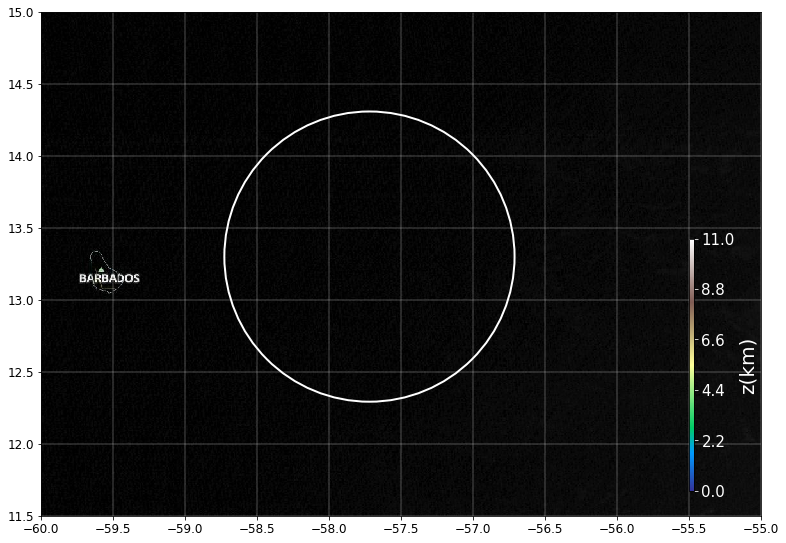

In [344]:
makeMovie()

# Tests

In [17]:
col_top = 'g'
col_bottom = 'y'
outputfilepath = os.path.join(outputdir,outputFileName(now))
# try makeImage
makeImage(goes_image,now,allsondes,dt_fade,col_top,col_bottom,outputfilepath)

In [467]:
print(now)
sondes = getMatchingSondes(allsondes,now,dt_fade)
for sonde in sondes:
    print(sonde.alt.values[-1])

2020-01-24 10:15:00
10067.296
10161.817
10179.263
10174.7295
1179.4199
10165.972


In [431]:
dt = datetime.timedelta(seconds=60)
start = datetime.datetime.now()
dtime = start
for i in range(10):
    dtime = start + i*dt
    print('make %s'%outputFileName(dtime))

make 2020-02-08T16:50:00Z_HALO.jpg
make 2020-02-08T16:50:00Z_HALO.jpg
make 2020-02-08T16:50:00Z_HALO.jpg
make 2020-02-08T16:50:00Z_HALO.jpg
make 2020-02-08T17:00:00Z_HALO.jpg
make 2020-02-08T17:00:00Z_HALO.jpg
make 2020-02-08T17:00:00Z_HALO.jpg
make 2020-02-08T17:00:00Z_HALO.jpg
make 2020-02-08T17:00:00Z_HALO.jpg
make 2020-02-08T17:00:00Z_HALO.jpg
